# Introduction

## Context 

In [1]:
# TODO: brief overview of projet goals

## Imports

In [2]:
import math

# graphs
import matplotlib.pyplot as plt

# other libraries
import missingno as msno

# data
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

# preprocessing

# Kaggle Kernel for feature engineering
# import src.features.lighthgbm_with_simple_features

# from src.features.lighthgbm_with_simple_features import *
# graphic settings
sns.set()

from src.features.lightgbm_with_simple_features import *

## Data imports

* Dataset consists of one main table and 6 extra tables linked by ids
    * `application_test` has no `TARGET` column, will only be used for data drift detection 
* For our Minimum Viable Product we will only use the main table
* Once the MVP is running, other tables could be used to improve model predictions.


![](../references/home_credit.png)

In [3]:
# TODO: use other tables
app_train = pd.read_csv("../data/raw/application_train.csv", index_col="SK_ID_CURR")
# app_test = pd.read_csv("../data/raw/application_test.csv", index_col="SK_ID_CURR")

# First look at data

### Shape, dtypes etc

In [4]:
app_train.shape

(307511, 121)

In [5]:
app_train.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Data columns (total 121 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    TARGET                        307511 non-null  int64  
 1    NAME_CONTRACT_TYPE            307511 non-null  object 
 2    CODE_GENDER                   307511 non-null  object 
 3    FLAG_OWN_CAR                  307511 non-null  object 
 4    FLAG_OWN_REALTY               307511 non-null  object 
 5    CNT_CHILDREN                  307511 non-null  int64  
 6    AMT_INCOME_TOTAL              307511 non-null  float64
 7    AMT_CREDIT                    307511 non-null  float64
 8    AMT_ANNUITY                   307499 non-null  float64
 9    AMT_GOODS_PRICE               307233 non-null  float64
 10   NAME_TYPE_SUITE               306219 non-null  object 
 11   NAME_INCOME_TYPE              307511 non-null  object 
 12   NAME_EDUCATION_TYPE         

To many columns to read each definition, let's group them by dtypes

In [6]:
# Column by dtypes
app_train.dtypes.value_counts()

float64    65
int64      40
object     16
Name: count, dtype: int64

In [7]:
# number of classes for categorical features
app_train.select_dtypes("object").nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
# Sample preview
app_train.sample(10)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
318591,0,Cash loans,F,N,Y,0,157500.0,585000.0,28273.5,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
110647,0,Cash loans,F,N,N,0,202500.0,1321020.0,35554.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
226750,0,Cash loans,F,Y,Y,0,202500.0,545040.0,36553.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
257504,0,Cash loans,M,N,Y,0,225000.0,338832.0,26901.0,292500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
201341,0,Revolving loans,F,N,Y,0,180000.0,157500.0,7875.0,180000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
310067,1,Cash loans,M,N,Y,0,270000.0,675000.0,53329.5,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
300562,0,Cash loans,F,N,Y,0,225000.0,142200.0,8293.5,112500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,4.0
210937,0,Cash loans,F,Y,N,0,202500.0,607500.0,39411.0,607500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
372317,0,Revolving loans,F,N,Y,0,247500.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Get variable definitions 

In [9]:
# Load description file
feature_description = pd.read_csv(
    "../data/raw/HomeCredit_columns_description.csv", encoding="unicode_escape"
)
feature_description = feature_description.set_index("Row")[
    ["Description", "Special", "Table"]
]


def get_definition(feature):
    """
    Prints definition of a feature. Not sensitive to case.

    Parameters
    ----------
    feature: str
        Name of the feature
    """
    with pd.option_context("display.max_colwidth", None):
        display(pd.DataFrame(feature_description.loc[feature.upper(), :]))


get_definition("APARTMENTS_MODE")

,APARTMENTS_MODE
Description,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor"
Special,normalized
Table,application_{train|test}.csv


## Describe

In [10]:
app_train_desc = app_train.describe().T
with pd.option_context(
    "display.max_row", None, "display.float_format", "{:20,.2f}".format
):
    display(app_train_desc)

,count,mean,std,min,25%,50%,75%,max
TARGET,"307,511.00",0.08,0.27,0.00,0.00,0.00,0.00,1.00
CNT_CHILDREN,"307,511.00",0.42,0.72,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,"307,511.00","168,797.92","237,123.15","25,650.00","112,500.00","147,150.00","202,500.00","117,000,000.00"
AMT_CREDIT,"307,511.00","599,026.00","402,490.78","45,000.00","270,000.00","513,531.00","808,650.00","4,050,000.00"
AMT_ANNUITY,"307,499.00","27,108.57","14,493.74","1,615.50","16,524.00","24,903.00","34,596.00","258,025.50"
AMT_GOODS_PRICE,"307,233.00","538,396.21","369,446.46","40,500.00","238,500.00","450,000.00","679,500.00","4,050,000.00"
REGION_POPULATION_RELATIVE,"307,511.00",0.02,0.01,0.00,0.01,0.02,0.03,0.07
DAYS_BIRTH,"307,511.00","-16,037.00","4,363.99","-25,229.00","-19,682.00","-15,750.00","-12,413.00","-7,489.00"
DAYS_EMPLOYED,"307,511.00","63,815.05","141,275.77","-17,912.00","-2,760.00","-1,213.00",-289.00,"365,243.00"
DAYS_REGISTRATION,"307,511.00","-4,986.12","3,522.89","-24,672.00","-7,479.50","-4,504.00","-2,010.00",0.00


## Missing values

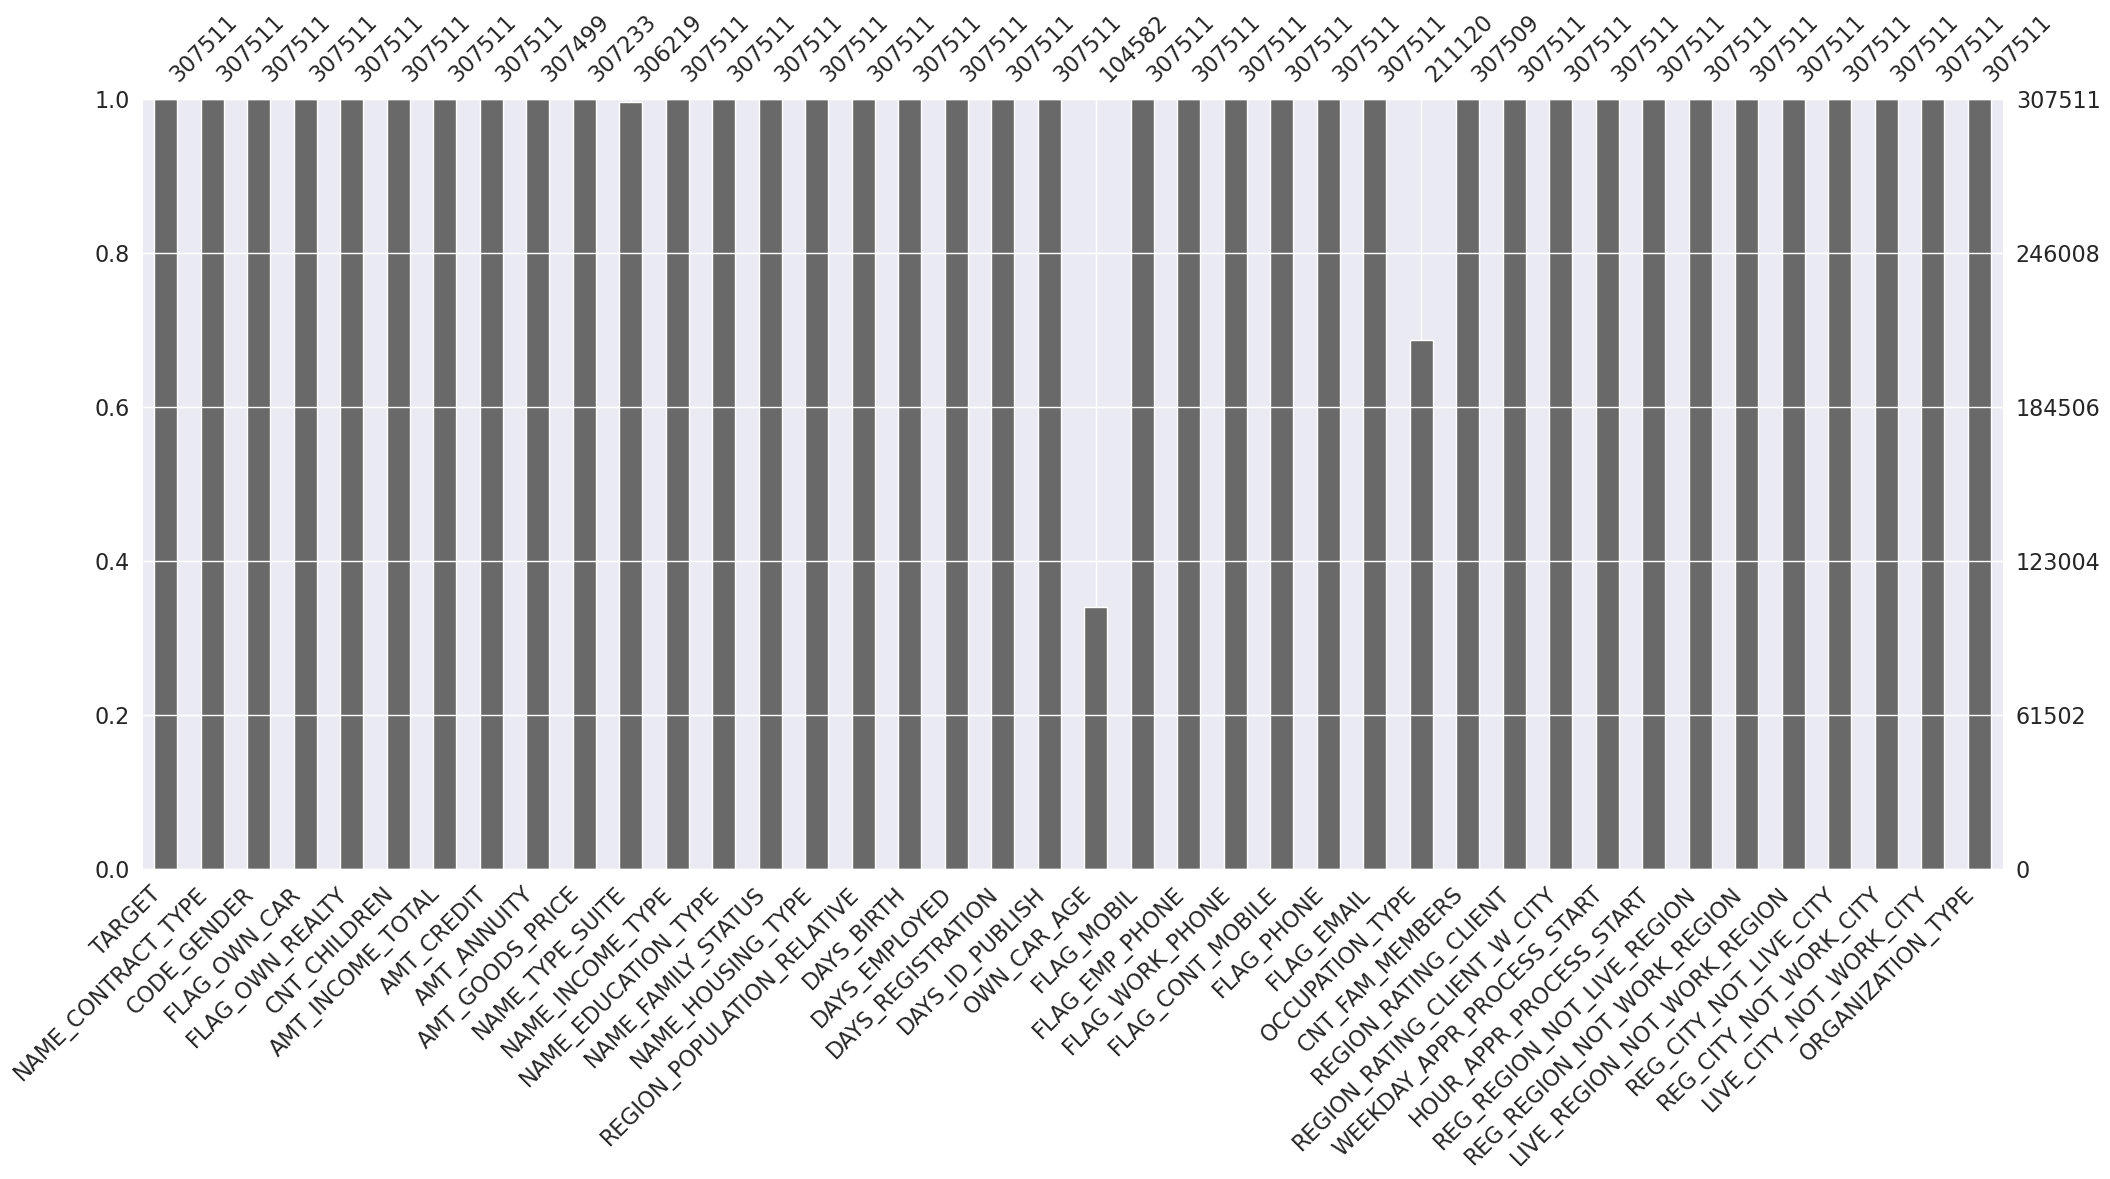

In [11]:
# df divided in 3 plots because msno has a 50 column limit (issue with matplotlib version)
msno.bar(app_train.iloc[:, :40]);

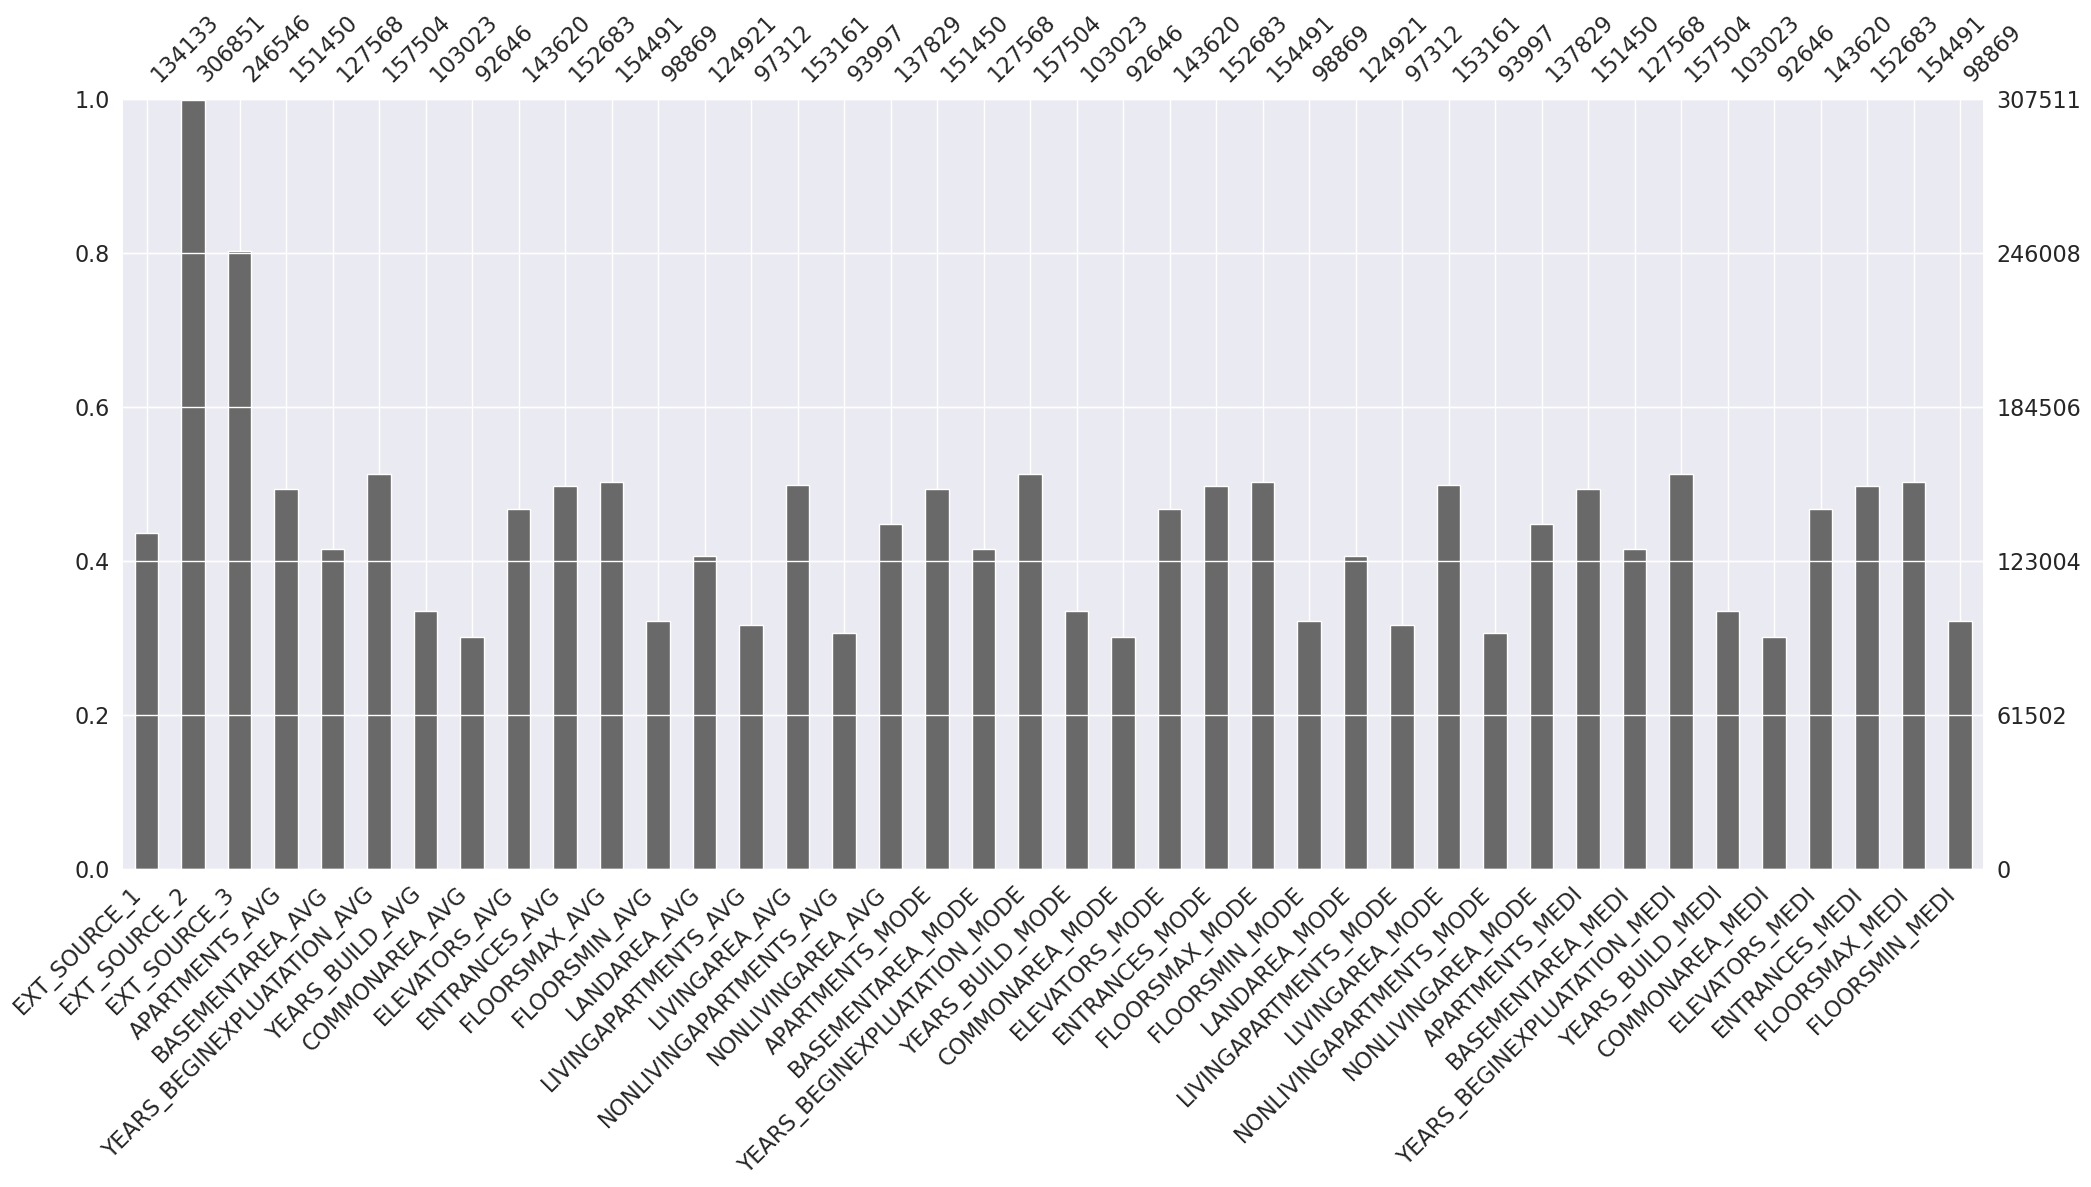

In [12]:
msno.bar(app_train.iloc[:, 40:80]);

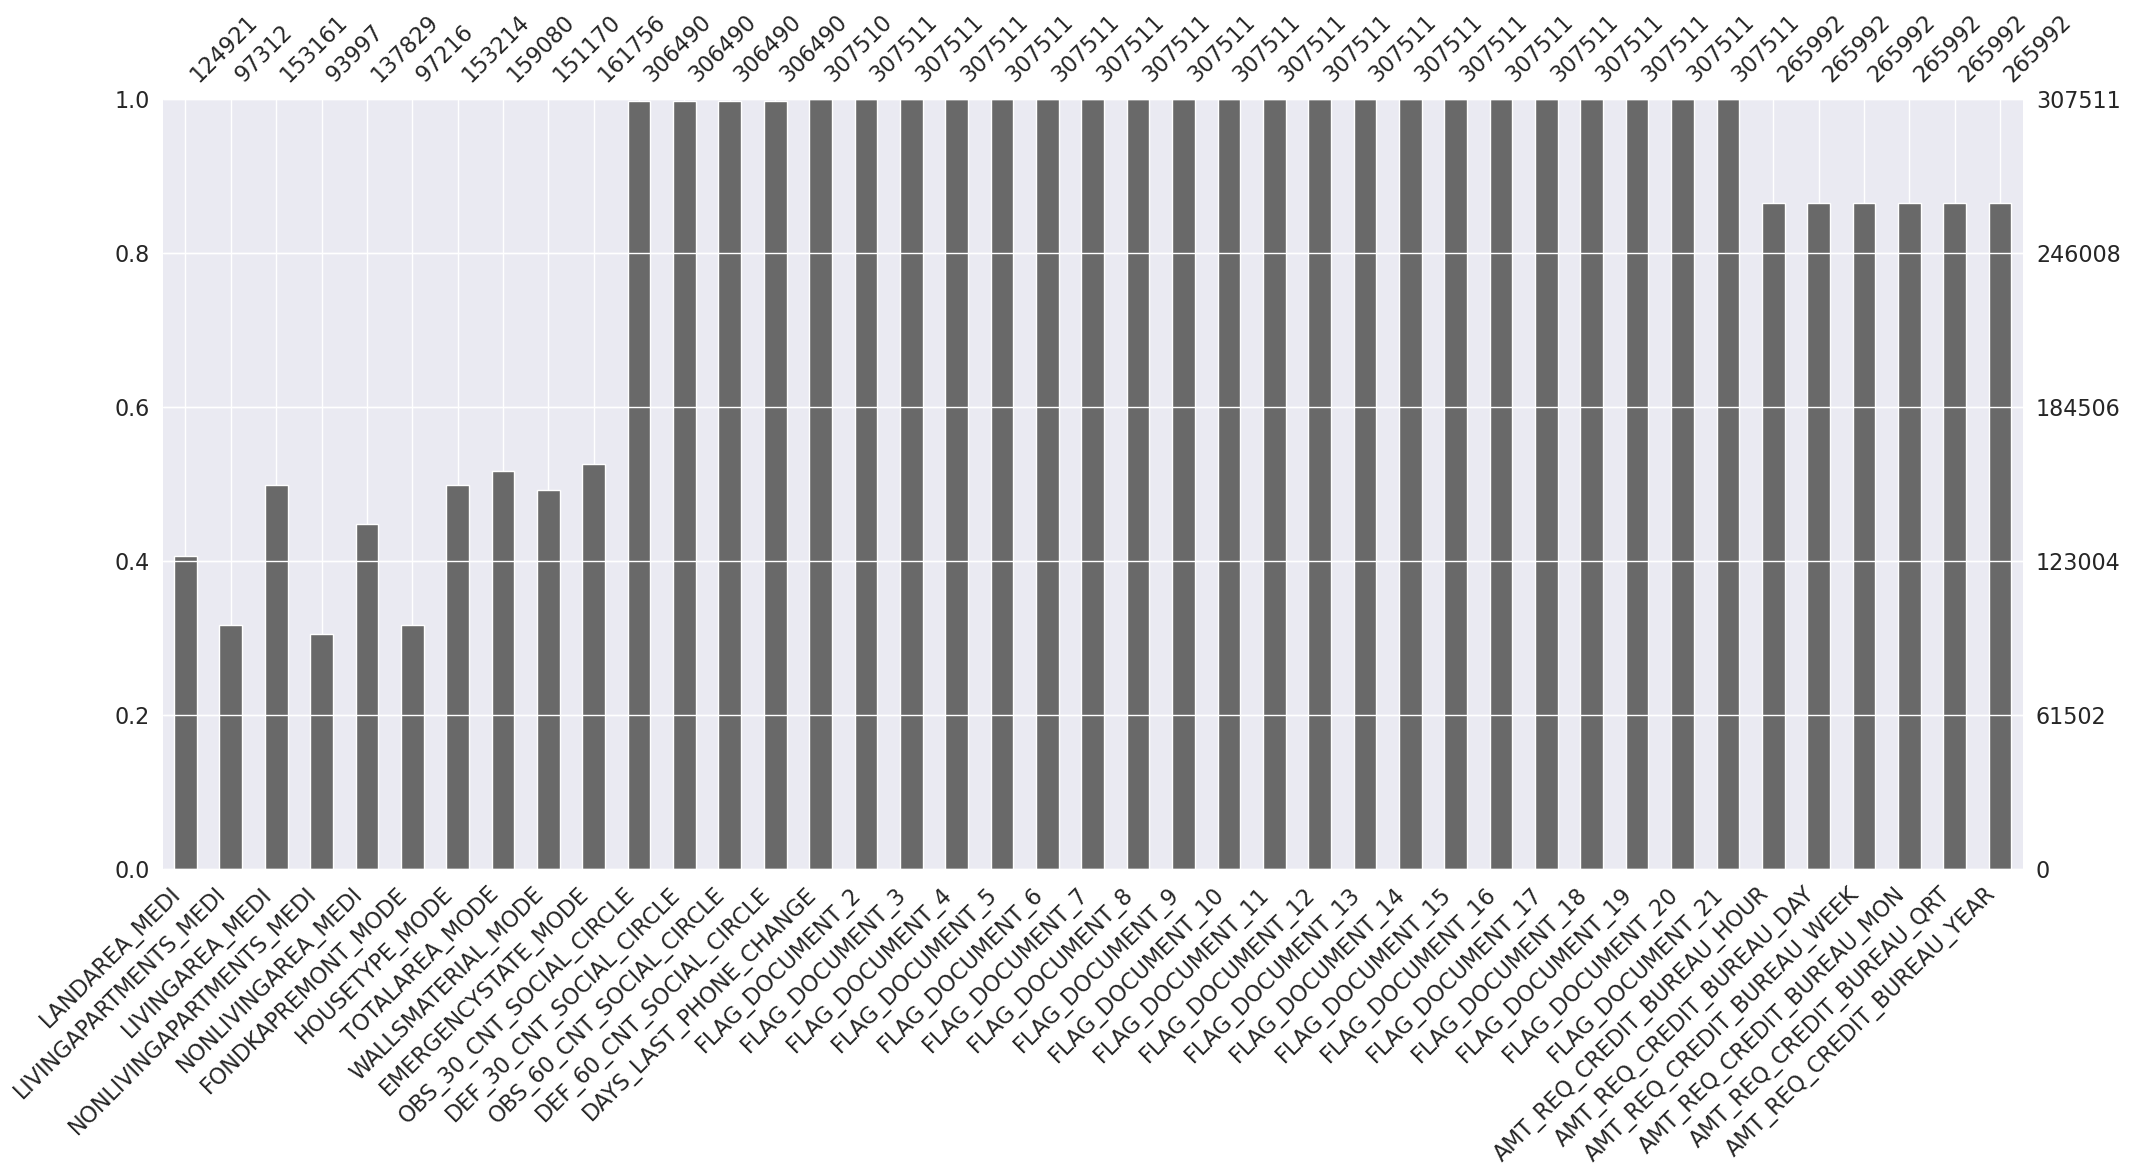

In [13]:
msno.bar(app_train.iloc[:, 80:]);

In [14]:
# Columns that are the most empty
tmp = app_train.isna().mean().sort_values(ascending=False).head(20)
tmp

COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_AVG               0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MEDI               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MODE               0.593767
dtype: float64

<div class="alert alert-block alert-warning">
<b>Comment : </b></div>

most of the columns contain NaN. We don't know yet which features are important, we will keep them all for now.

## Duplicates

In [15]:
app_train.index.duplicated().any()

False

In [16]:
app_train.duplicated().any()

False

## Outliers and anomalies

### Z-score and boxplot detection

AMT_INCOME_TOTAL              492.703449
AMT_REQ_CREDIT_BUREAU_QRT     350.470589
OBS_30_CNT_SOCIAL_CIRCLE      144.506214
OBS_60_CNT_SOCIAL_CIRCLE      144.117631
AMT_REQ_CREDIT_BUREAU_MON      31.242339
CNT_CHILDREN                   25.733871
CNT_FAM_MEMBERS                19.597532
AMT_ANNUITY                    15.931509
AMT_REQ_CREDIT_BUREAU_YEAR     12.585586
OWN_CAR_AGE                     9.645167
AMT_GOODS_PRICE                 9.501557
AMT_CREDIT                      8.574059
DAYS_REGISTRATION               5.588007
DAYS_LAST_PHONE_CHANGE          4.026504
HOUR_APPR_PROCESS_START         3.693833
DAYS_ID_PUBLISH                 2.784328
DAYS_EMPLOYED                   2.133617
DAYS_BIRTH                      2.106335
dtype: float64


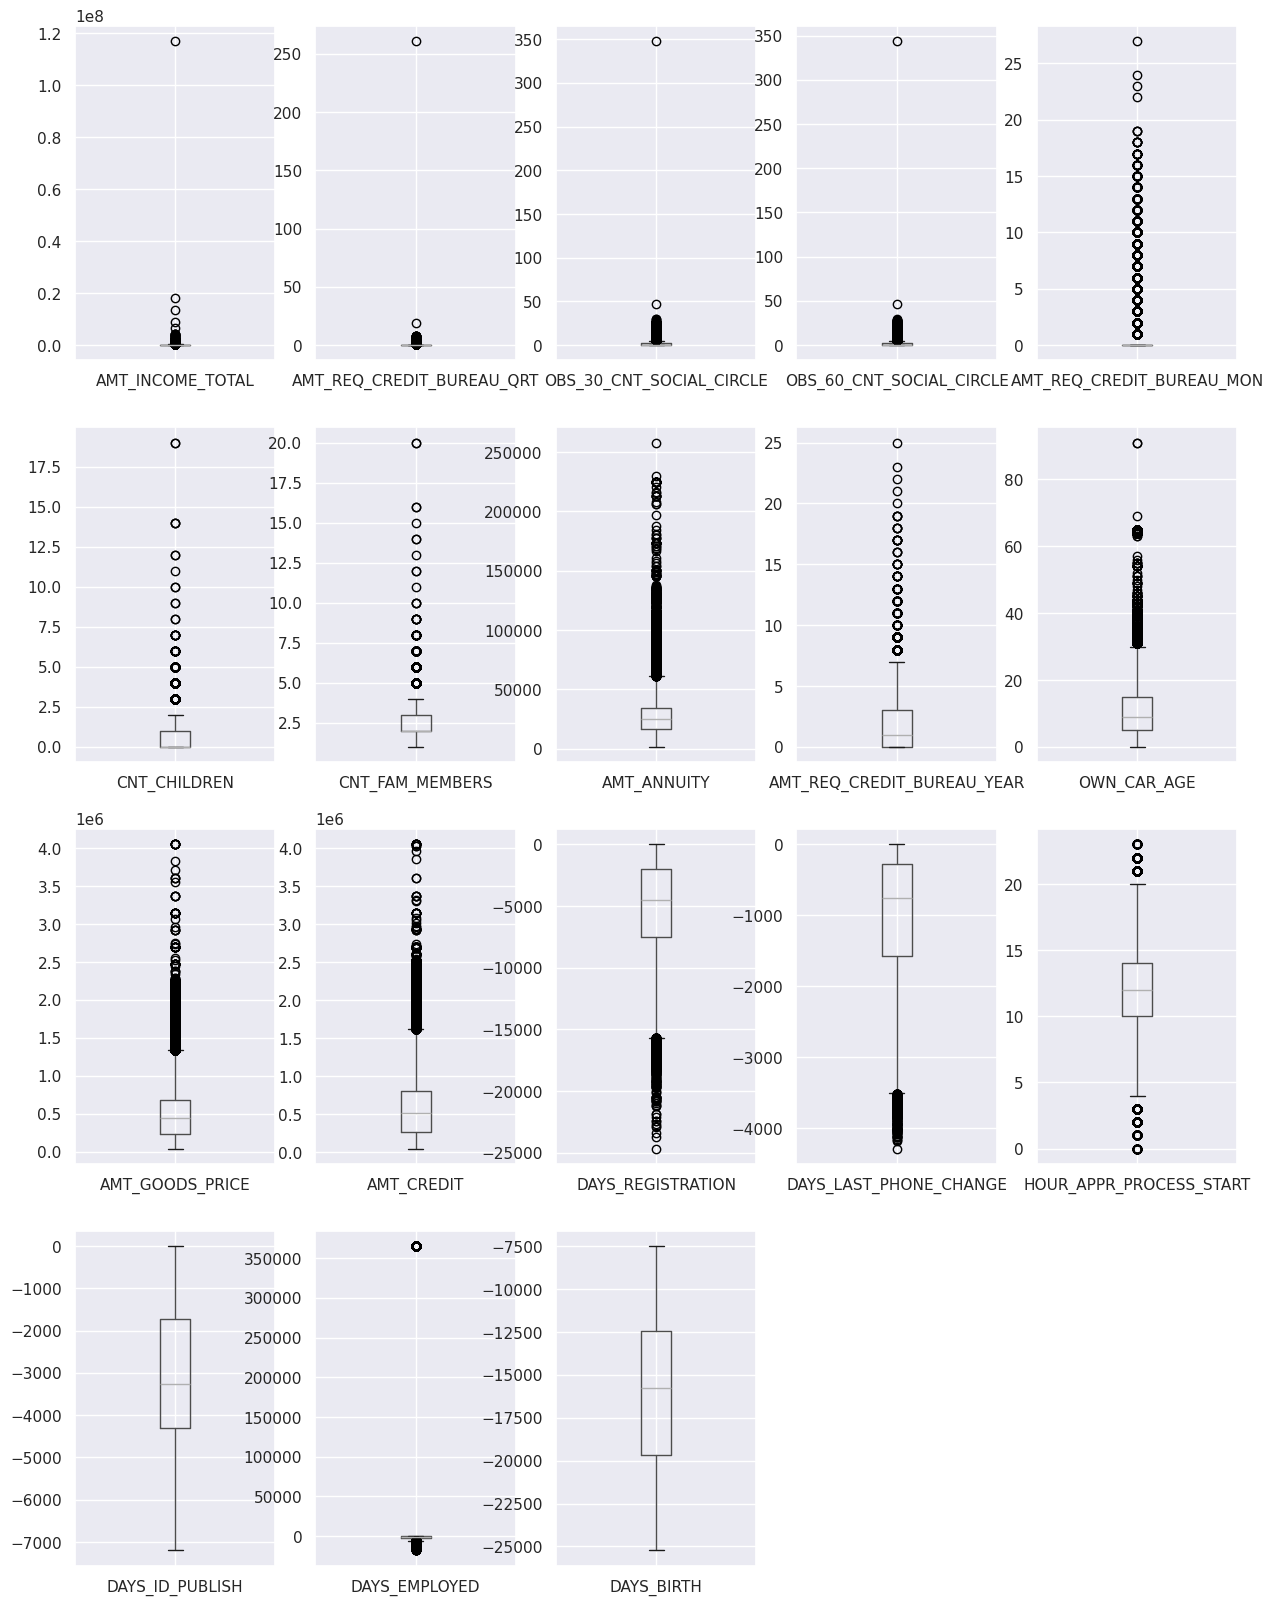

In [17]:
# Print boxplots for all numeric features
# filter out categorial num features
num_col = app_train.select_dtypes(np.number).nunique() > 10
num_col = num_col[num_col].index

# filter features with 0 to 1 values
bool_features = (app_train[num_col].max() - app_train[num_col].min()) <= 1
not_bool_features = bool_features[~bool_features].index

# select features with high Z-Score
feature_has_outliers = (
    scipy.stats.zscore(app_train[not_bool_features].fillna(0)).abs().max()
).sort_values(ascending=False)
feature_has_outliers = feature_has_outliers[feature_has_outliers > 2]

subset = feature_has_outliers.index
PLOT_LINES = len(subset)
PLOT_COL = 5
plt.figure(figsize=(15, 20))
for i, col in enumerate(app_train[subset]):
    plt.subplot(PLOT_LINES // PLOT_COL + 1, PLOT_COL, i + 1)
    app_train.boxplot(column=col)

print(feature_has_outliers.sort_values(ascending=False))

<div class="alert alert-block alert-warning">
<b>Comment : </b></div>

Detected outliers :
- `AMT_INCOME_TOTAL` : outlier but possibly real value
- `AMT_REQ_CREDIT_BUREAU_QRT` : outlier but possibly real value
- `OBS_30_CNT_SOCIAL_CIRCLE` : outlier but possibly real value
- `OBS_60_CNT_SOCIAL_CIRCLE` : outlier but possibly real value
- `DAYS_EMPLOYED` : impossible value, needs fixing


In [18]:
get_definition("OBS_30_CNT_SOCIAL_CIRCLE")

,OBS_30_CNT_SOCIAL_CIRCLE
Description,How many observation of client's social surroundings with observable 30 DPD (days past due) default
Special,NaN
Table,application_{train|test}.csv


### Impossible values

In [ ]:
# Detect features with both positive and negative values
values_positive_and_negative = (
    app_train.select_dtypes(np.number).min() * app_train.select_dtypes(np.number).max()
) < 0
values_positive_and_negative[values_positive_and_negative]

In [ ]:
app_train.boxplot(column="DAYS_EMPLOYED");

### By column name

In [ ]:
def cols_containing(pattern: str):
    """
    Returns list of column names that contain a pattern.

    Parameters
    ----------
    pattern: str
        Pattern to look for in column names. Case insensitive.

    Returns
    -------
    List
        List of column names

    """
    return app_train.columns[app_train.columns.str.contains(pattern.upper())].to_list()

In [ ]:
# convert negative days to years
(app_train[cols_containing("days")] / -365).describe()

<div class="alert alert-block alert-danger">
<b>Comment : </b>Min value of -1000 years employed is impossible, is it a single outlier or a common value?</div>

In [ ]:
(app_train.DAYS_EMPLOYED / -365).hist();

In [ ]:
# check for impossible values in time variables
app_train[cols_containing("year")].describe()

# Cleaning
Main table is already split in train/test, so we will apply the same cleaning process to both

## Fixing Outliers

In [ ]:
#  Main table is already split in train/test, so we will apply the same cleaning process to both
# Replace Outliers value by imputing NaN and add flag to keep track
# train
app_train["FLAG_ANOMALY_DAYS_EMPLOYED"] = app_train.DAYS_EMPLOYED > 365 * 100
outlier_value = app_train.DAYS_EMPLOYED.max()
app_train.DAYS_EMPLOYED.replace(outlier_value, np.nan, inplace=True)

In [ ]:
(app_train.DAYS_EMPLOYED / -365).hist();

In [ ]:
app_train[(app_train.AMT_INCOME_TOTAL > 1000000)].AMT_INCOME_TOTAL.shape

In [ ]:
# Print dist of AMT_INCOME_TOTAL without extreme outliers for better visibility
app_train[(app_train.AMT_INCOME_TOTAL < 1000000)].AMT_INCOME_TOTAL.hist();

# Feature engineering

In [ ]:
# use financial feature engineering from Kaggle kernel as suggested by project guidelines
# source: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
num_rows = None
df = application_train_test(num_rows)
# Process bureau and bureau_balance
bureau = bureau_and_balance(num_rows)
print("Bureau df shape:", bureau.shape)
df = df.join(bureau, how="left", on="SK_ID_CURR")
del bureau
gc.collect()
# Process previous_applications
prev = previous_applications(num_rows)
print("Previous applications df shape:", prev.shape)
df = df.join(prev, how="left", on="SK_ID_CURR")
del prev
gc.collect()
# Process POS-CASH balance
pos = pos_cash(num_rows)
print("Pos-cash balance df shape:", pos.shape)
df = df.join(pos, how="left", on="SK_ID_CURR")
del pos
gc.collect()
# Process installments payments
ins = installments_payments(num_rows)
print("Installments payments df shape:", ins.shape)
df = df.join(ins, how="left", on="SK_ID_CURR")
del ins
gc.collect()
# Process credit card balance
cc = credit_card_balance(num_rows)
print("Credit card balance df shape:", cc.shape)
df = df.join(cc, how="left", on="SK_ID_CURR")
del cc
gc.collect()

print(df.shape)
# drop na targets
df = df[df.TARGET.notna()]
# replace inf values not supported by sklearn
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# One hot encoding for 16 columns still containing objects
df = pd.get_dummies(
    df, columns=df.select_dtypes("object").columns.to_list(), drop_first=True
)
print(df.shape)

# Graphical analysis

## Target

In [ ]:
# Target
app_train.TARGET.value_counts(normalize=True).plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=None,
    title="Target classes are imbalanced",
)
plt.legend(["0: loan repaid", "1: payment difficulties"], loc="lower right")
plt.show()

## Bivariate analysis vs TARGET

### Categorical features

#### Low cardinality (few classes)

In [ ]:
not_float_cols = app_train.select_dtypes(["int", "bool", "object"]).nunique()
low_cardinality = not_float_cols[not_float_cols <= 4].index.to_list()
low_cardinality.remove("TARGET")

cols = 4
rows = math.ceil(len(low_cardinality) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 35))

grp = app_train.groupby("TARGET")
for r in range(rows):
    for c in range(cols):
        idx = r * cols + c
        if idx < len(low_cardinality):
            i = low_cardinality[idx]
            grp[i].value_counts(normalize=True).unstack().T.plot.bar(
                ax=axes[r, c], legend=True
            )
        else:
            break

#### Higher cardinality

In [ ]:
obj_cols = app_train.select_dtypes("object").nunique()
high_cardinality = obj_cols[(obj_cols > 4) & (obj_cols < 20)].index.to_list()

In [ ]:
cols = 2
rows = math.ceil(len(high_cardinality) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

grp = app_train.groupby("TARGET")
for r in range(rows):
    for c in range(cols):
        idx = r * cols + c
        if idx < len(high_cardinality):
            i = high_cardinality[idx]
            grp[i].value_counts(normalize=True).unstack().T.sort_values(by=1).plot.barh(
                ax=axes[r, c], legend=True
            )
        else:
            break
plt.tight_layout()
# app_train.groupby("TARGET")["NAME_INCOME_TYPE"].value_counts(
#     normalize=True
# ).unstack().T.sort_values(by=1).plot.barh();

In [ ]:
# app_train.groupby("TARGET")["OCCUPATION_TYPE"].value_counts(
#     normalize=True
# ).unstack().T.sort_values(by=1).plot.barh();

### Numeric features

#### Correlation Matrix

In [ ]:
# Select only features with highest correlation to target
top_target_corr = (
    df.select_dtypes(np.number)
    .corrwith(df.TARGET)
    .abs()
    .sort_values(ascending=False)
    .head(15)
    .index
)

plt.figure(figsize=(6, 6))
sns.set_theme(style="white")  # for white background
sns.heatmap(
    df[top_target_corr].corr(),
    # shape
    mask=np.triu(df[top_target_corr].corr()),
    square=True,
    linewidths=0.6,
    # diverging colormap
    cmap=plt.cm.RdBu,
    center=0,
    vmin=-1,
    vmax=1,
    # annotations
    # annot=True,
    # annot_kws={"size": 20},
    # fmt=".2f",
    # cbar_kws={"shrink": 0.5},
)
plt.show();

In [ ]:
get_definition("EXT_SOURCE_3")

#### Distributions by target

In [ ]:
cols = 3
rows = int(len(top_target_corr) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 30))

for r in range(rows):
    for c in range(cols):
        sns.kdeplot(
            df[top_target_corr],
            x=top_target_corr[r * 3 + c],
            hue="TARGET",
            fill=True,
            common_norm=False,
            ax=axes[r, c],
            warn_singular=False,
            palette="tab10",
        )

# Save transformed data

In [ ]:
df.info()

In [ ]:
# save using pickle to keep exact dtypes (csv will result in bigger files and higher memory footprint)
df.to_pickle("../data/processed/data_cleaned.pkl")
# use sample in API
df.sample(frac=0.01).to_pickle("../data/processed/app_train_cleaned_sample.pkl")